# Routines to compare PYPIT with LowRedux (v0.2.2)

In [21]:
%matplotlib inline

In [73]:
# imports
from scipy import stats
#
from linetools.spectra import io as lsio
from linetools.spectra.xspectrum1d import XSpectrum1D
# 
import matplotlib as mpl
mpl.rcParams['font.family'] = 'stixgeneral'
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

## ToDo:

* Deal with air vs. vacuum

## Filenames

### LowRedux

In [2]:
scifile = '/Users/xavier/PYPIT/Kast_red/Science/sci-r153.fits.gz'
lwrdx_wavefile = '/Users/xavier/PYPIT/Kast_red/wave-r124.fits'

### PYPIT

In [45]:
pypit_boxfile = '/Users/xavier/PYPIT/TEST_SUITES/Kast_red/MasterFrames/J0025-0312_000_boxcar.fits'
pypit_skyfile = '/Users/xavier/PYPIT/TEST_SUITES/Kast_red/MasterFrames/J0025-0312_000_sky.fits'
pypit_skysubfile = '/Users/xavier/PYPIT/TEST_SUITES/Kast_red/MasterFrames/J0025-0312_000_skysub.fits'
pypit_varfile = '/Users/xavier/PYPIT/TEST_SUITES/Kast_red/MasterFrames/J0025-0312_000_var.fits'
pypit_skyboxfile = '/Users/xavier/PYPIT/TEST_SUITES/Kast_red/MasterFrames/J0025-0312_000_skybox.fits'
pypit_objtrcfile = '/Users/xavier/PYPIT/TEST_SUITES/Kast_red/MasterFrames/J0025-0312_000_objtrc.fits'
pypit_wavefile= '/Users/xavier/PYPIT/TEST_SUITES/Kast_red/MasterFrames/mswvimg_red_000.fits'

## Init

In [4]:
lrdx_scihdu = fits.open(scifile)
sciobj = Table(lrdx_scihdu[5].data)[0] # Might have to deal with more than one obj

---
## Traces

### Read

In [93]:
# Read PYPIT
pypit_objtrc = fits.open(pypit_objtrcfile)[0].data
if pypit_objtrc.shape[1] > 1:
    raise ValueError('Not ready for multiple objects')
# Read LowRedux
lwrdx_objtrc = sciobj['XPOS']

In [94]:
print(pypit_objtrc.shape, lwrdx_objtrc.shape)

((1199, 1), (1200,))


### Plot

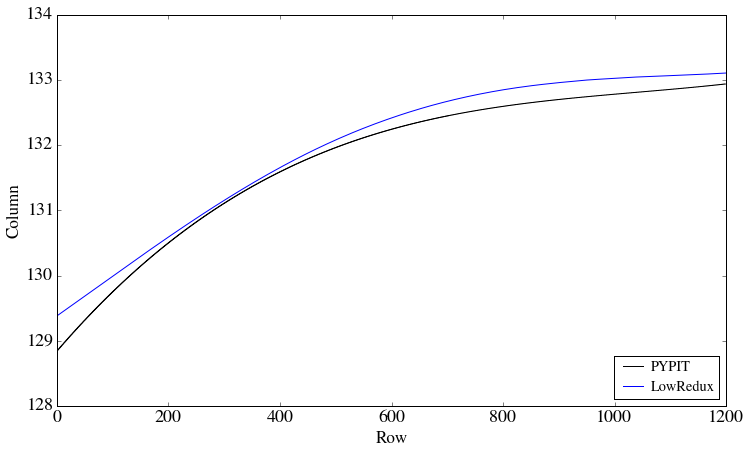

In [95]:
plt.clf()
plt.figure(figsize=(12,7))
ax = plt.gca()
# PYPIT
ax.plot(pypit_objtrc[:,0], 'k-', drawstyle='steps', label='PYPIT')
# LowRedux
ax.plot(lwrdx_objtrc, '-', color='blue', label='LowRedux')
# Axes
#ax.set_ylim(0.,np.median(pys2n)*2.)
ax.set_xlabel('Row',fontsize=17.)
ax.set_ylabel('Column',fontsize=17.)
# Legend
legend = plt.legend(loc='lower right', borderpad=0.3,
            handletextpad=0.3, fontsize='x-large')
# Finish
plt.show()
plt.close()
#

---
## Sky Models

### Load sky and wavelength images

In [56]:
# PYPIT
pypit_wave = fits.open(pypit_wavefile)[0].data
pypit_var = fits.open(pypit_varfile)[0].data
pypit_sky = fits.open(pypit_skyfile)[0].data
pypit_skysub = fits.open(pypit_skysubfile)[0].data
pypit_objmsk = fits.open(pypit_objtrcfile)[1].data.astype(int)
# LowRedux
lwrdx_wave = fits.open(lwrdx_wavefile)[0].data
lwrdx_proc = lrdx_scihdu[0].data
lwrdx_ivar = lrdx_scihdu[1].data
lwrdx_sky = lrdx_scihdu[2].data

### Sky Spectrum

#### PYPIT

In [19]:
pypit_skyspec = lsio.readspec(pypit_skyboxfile)

#### LowRedux

In [9]:
lwrdx_skywv = sciobj['WAVE_BOX']
lwrdx_skyfx = sciobj['SKY_BOX']

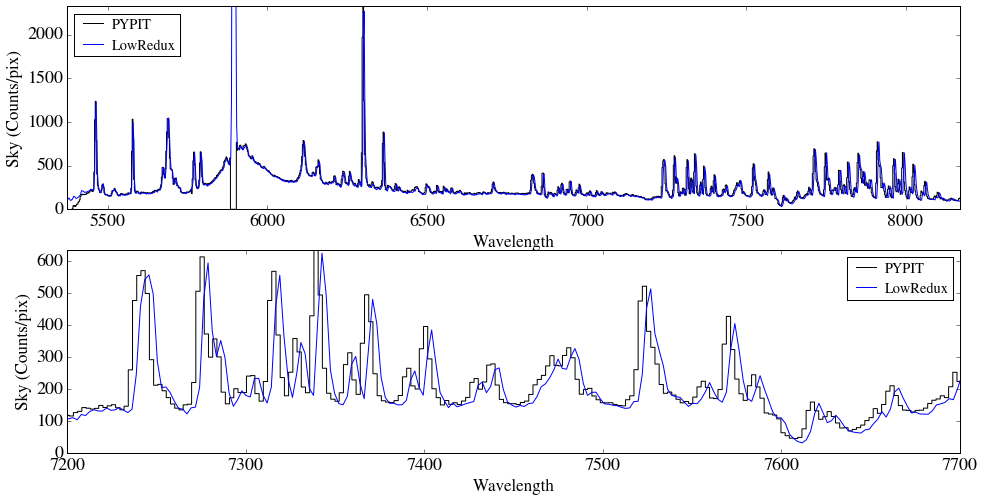

In [113]:
plt.clf()
plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(2, 1)
# Full
ax = plt.subplot(gs[0])
# PYPIT
#ax.scatter(pypit_skywv,pypit_skyfx, marker='+', facecolor='black', label='PYPIT', s=3.)
ax.plot(pypit_skyspec.dispersion, pypit_skyspec.flux, 'k-', label='PYPIT', drawstyle='steps')
# LowRedux
ax.plot(lwrdx_skywv, lwrdx_skyfx/(2.*sciobj['BOX_RAD']), '-', color='blue', label='LowRedux')
# Axes
ax.set_xlim(np.min(pypit_skyspec.dispersion.value),np.max(pypit_skyspec.dispersion.value))
ax.set_ylim(0.,np.max(pypit_skyspec.flux))
ax.set_xlabel('Wavelength',fontsize=17.)
ax.set_ylabel('Sky (Counts/pix)',fontsize=17.)
# Legend
legend = plt.legend(loc='upper left', borderpad=0.3,
            handletextpad=0.3, fontsize='x-large')

# ZOOM
axz = plt.subplot(gs[1])
# PYPIT
#axz.scatter(pypit_skywv,pypit_skyfx, marker='o', facecolor='black', label='PYPIT',s=7.)
axz.plot(pypit_skyspec.dispersion, pypit_skyspec.flux, 'k-', label='PYPIT', drawstyle='steps')
# LowRedux
axz.plot(lwrdx_skywv, lwrdx_skyfx/(2.*sciobj['BOX_RAD']), '-', color='blue', label='LowRedux')
# Axes
zlim = [7200., 7700.]
axz.set_xlim(zlim)
ymx = np.max( pypit_skyfx[np.where((pypit_skywv>zlim[0])&(pypit_skywv<zlim[1]))])
axz.set_ylim(0.,ymx)
axz.set_xlabel('Wavelength',fontsize=17.)
axz.set_ylabel('Sky (Counts/pix)',fontsize=17.)
# Legend
legend = plt.legend(loc='upper right', borderpad=0.3,
            handletextpad=0.3, fontsize='x-large')

# Finish
plt.show()
plt.close()
#

### $\chi^2$ images

#### PYPIT

In [47]:
pypit_resid = pypit_skysub / np.sqrt(pypit_var)

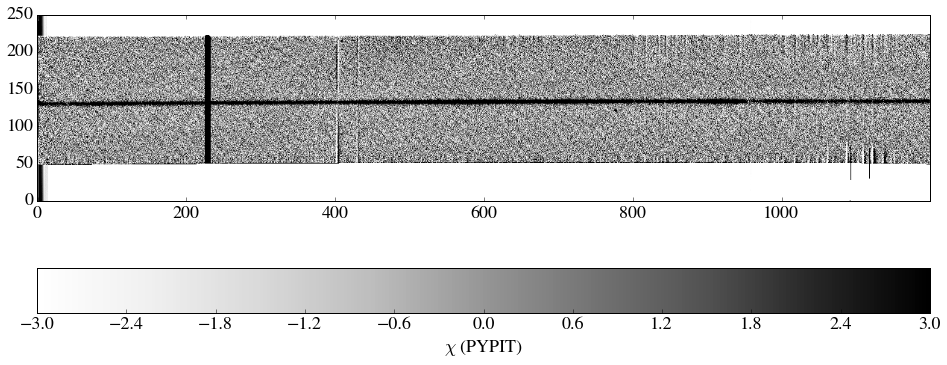

In [110]:
plt.clf()
plt.figure(figsize=(16,8))
#
cm = plt.get_cmap('Greys') 
mplt = plt.imshow(pypit_resid.T, origin='lower', cmap=cm)
mplt.set_clim(vmin=-3, vmax=3.)
cb = plt.colorbar(mplt,orientation='horizontal',)
cb.set_label(r'$\chi$ (PYPIT)',fontsize=18.)
#
plt.show()
plt.close()

#### LowRedux

In [57]:
lwrdx_resid = (lwrdx_proc-lwrdx_sky) * np.sqrt(lwrdx_ivar)

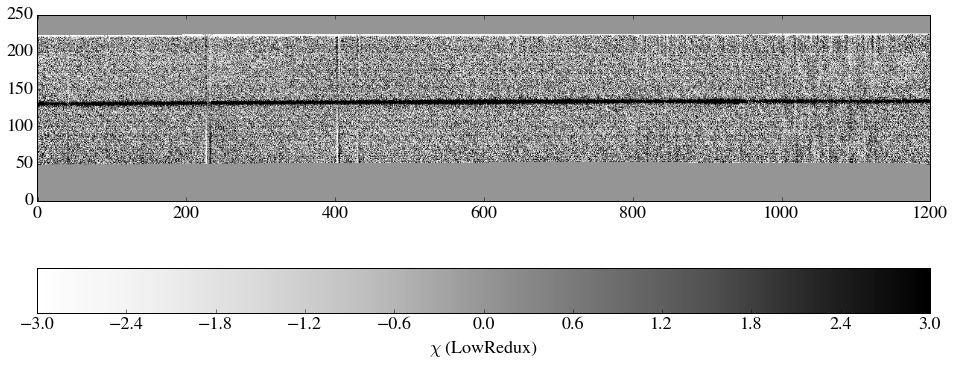

In [99]:
plt.clf()
plt.figure(figsize=(16,8))
#
cm = plt.get_cmap('Greys') 
mplt = plt.imshow(lwrdx_resid.T, origin='lower', cmap=cm)
mplt.set_clim(vmin=-3, vmax=3.)
cb = plt.colorbar(mplt,orientation='horizontal')
cb.set_label(r'$\chi$ (LowRedux)',fontsize=18.)
#
plt.show()
plt.close()

### $\chi^2$ histogram

#### Select regions  (near object)

In [80]:
# Median size of box car
dx = np.median(np.sum(pypit_objmsk[:,:,0],axis=1))
#
pypit_skymask = np.zeros_like(pypit_sky)
# Generate sky regions near the object trace
for ii in xrange(pypit_sky.shape[0]):
    # Left
    idx = np.arange(int(pypit_objtrc[ii,0]-dx*3), int(pypit_objtrc[ii,0]-dx))
    pypit_skymask[ii,idx] = 1
    # Right
    idx = np.arange(int(pypit_objtrc[ii,0]+dx), int(pypit_objtrc[ii,0]+dx*3))
    pypit_skymask[ii,idx] = 1
# 
skypix = np.where(pypit_skymask==1)

In [81]:
xdb.ximshow(pypit_skymask*pypit_resid)

#### Calculate $\chi$

In [82]:
# PYPIT
pypit_chi = pypit_resid[skypix]
# LowRedux
lwrdx_chi = lwrdx_resid[skypix]

#### Histograms

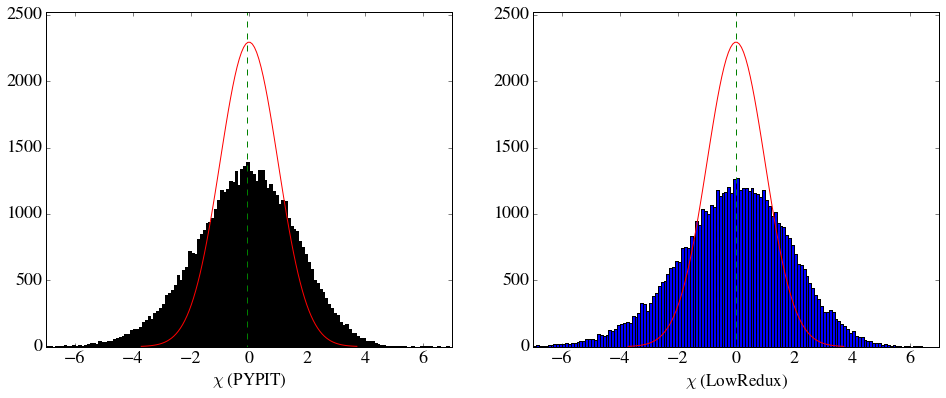

In [102]:
# Boundaries
minv, maxv = -7., 7.
binsz = 0.1

# Set the boundaries sensibly given binsz
i0 = int( minv / binsz) - 1
i1 = int( maxv / binsz) + 1
rng = tuple( binsz*np.array([i0,i1]) )
nbin = i1-i0

# Plot
plt.clf()
plt.figure(figsize=(16,6))
gs = gridspec.GridSpec(1, 2)

# PYPIT
axp = plt.subplot(gs[0])
# Histogram
hist, edges = np.histogram(pypit_chi, range=rng, bins=nbin)
axp.bar(edges[:-1], hist, width=binsz, color='black')#, alpha=kwargs['alpha'])
# PDF for Gaussian
area = pypit_chi.size * binsz
xppf = np.linspace(stats.norm.ppf(0.0001), stats.norm.ppf(0.9999), 100)
yppf = area*stats.norm.pdf(xppf)
axp.plot(xppf, yppf, 'r-', alpha=1.0)
# Median
axp.plot([np.median(pypit_chi)]*2, [-9e9,9e9], 'g--')
#
axp.set_xlim(minv,maxv)  
axp.set_ylim(0., np.max(yppf)*1.1)  
axp.set_xlabel(r'$\chi$ (PYPIT)', fontsize=17)

# LowRedux
axl = plt.subplot(gs[1])
# Histogram
hist, edges = np.histogram(lwrdx_chi, range=rng, bins=nbin)
axl.bar(edges[:-1], hist, width=binsz)#, alpha=kwargs['alpha'])
# PDF for Gaussian
area = lwrdx_chi.size * binsz
yppf = area*stats.norm.pdf(xppf)
axl.plot(xppf, yppf, 'r-', alpha=1.0)
# Median
axl.plot([np.median(lwrdx_chi)]*2, [-9e9,9e9], 'g--')
#
axl.set_xlim(minv,maxv)  
axl.set_ylim(0., np.max(yppf)*1.1)  
axl.set_xlabel(r'$\chi$ (LowRedux)', fontsize=17)

# Finish
plt.show()
plt.close()

In [68]:
pypit_chi

array([ -7.14612217e-13,  -7.96627993e-13,  -7.61350150e-13, ...,
         4.66222670e-01,   2.02715000e+00,   1.74688322e+00])

---
## Compare Boxcar Spectra

In [90]:
# Read/Load
pypit_boxspec = lsio.readspec(pypit_boxfile)
# Read LowRedux
sig = np.sqrt(sciobj['MASK_BOX']/(sciobj['SIVAR_BOX'] + (sciobj['MASK_BOX']==0)))
lwrdx_boxspec = XSpectrum1D.from_tuple( (sciobj['WAVE_BOX'], sciobj['FLUX_BOX'], sig) )

### Quick plot of the spectra

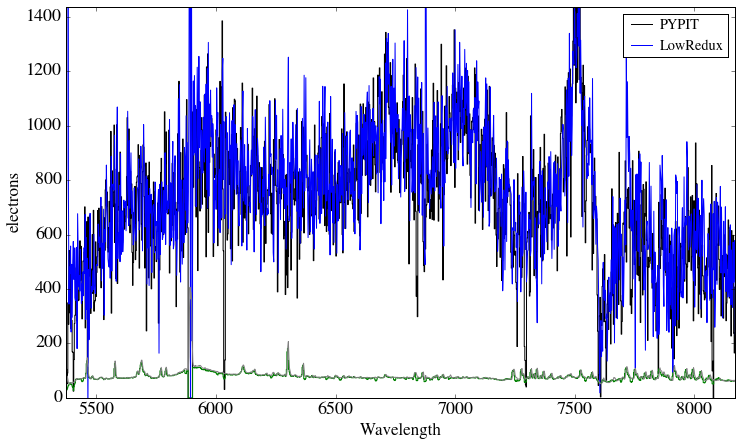

In [109]:
plt.clf()
plt.figure(figsize=(12,7))
ax = plt.gca()
ymax = np.median(pypit_boxspec.flux)*2.
# PYPIT
ax.plot(pypit_boxspec.dispersion, pypit_boxspec.flux, 'k-', drawstyle='steps',label='PYPIT')
ax.plot(pypit_boxspec.dispersion, pypit_boxspec.sig, 'g-', drawstyle='steps')
# LowRedux
ax.plot(lwrdx_boxspec.dispersion, lwrdx_boxspec.flux, '-', color='blue',label='LowRedux')
ax.plot(lwrdx_boxspec.dispersion, lwrdx_boxspec.sig, '-', color='gray')
# Axes
ax.set_xlim(np.min(pypit_boxspec.dispersion.value), np.max(pypit_boxspec.dispersion.value))
ax.set_ylim(0.,ymax)
ax.set_xlabel('Wavelength',fontsize=17.)
ax.set_ylabel('electrons',fontsize=17.)
# Legend
legend = plt.legend(loc='upper right', borderpad=0.3,
            handletextpad=0.3, fontsize='x-large')
# Finish
plt.show()
plt.close()
#

### S/N

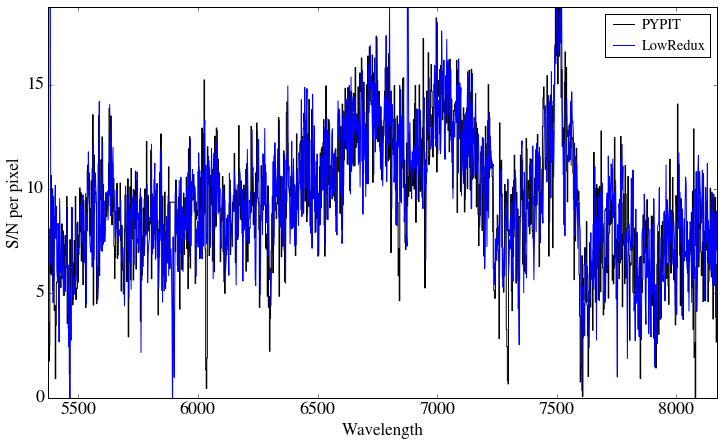

In [107]:
plt.clf()
plt.figure(figsize=(12,7))
ax = plt.gca()
ymax = np.median(pypit_boxspec.flux)*2.
# PYPIT
gdpy = pypit_boxspec.sig > 0.
pys2n =  pypit_boxspec.flux[gdpy]/pypit_boxspec.sig[gdpy]
ax.plot(pypit_boxspec.dispersion[gdpy],pys2n, 'k-', drawstyle='steps', label='PYPIT')
# LowRedux
gdlx = lwrdx_boxspec.sig > 0.
ax.plot(lwrdx_boxspec.dispersion[gdlx], lwrdx_boxspec.flux[gdlx]/lwrdx_boxspec.sig[gdlx], 
        '-', color='blue', label='LowRedux')
# Axes
ax.set_xlim(np.min(pypit_boxspec.dispersion.value), np.max(pypit_boxspec.dispersion.value))
ax.set_ylim(0.,np.median(pys2n)*2.)
ax.set_xlabel('Wavelength',fontsize=17.)
ax.set_ylabel('S/N per pixel',fontsize=17.)
# Legend
legend = plt.legend(loc='upper right', borderpad=0.3,
            handletextpad=0.3, fontsize='x-large')
# Finish
plt.show()
plt.close()
#